In [1525]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colormaps
import numpy as np
import geopandas as gpd
import seaborn as sns
from brokenaxes import brokenaxes 

# Population Wages

### What is the poverty line in the US?
**Source:** [Assistant Secretary for Planning and Evaluation](https://aspe.hhs.gov/topics/poverty-economic-mobility/poverty-guidelines) **Year:** 2024

In [1526]:
df_pov_guid = pd.read_csv('Datasets/Poverty_Guidelines.csv')

# Shorten column names.
df_pov_guid.columns = ['Household Size', 'US_PG', 'Alaska_PG', 'Hawaii_PG']

# Convert data entries to numeric values.
df_pov_guid['US_PG'] = df_pov_guid['US_PG'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)
df_pov_guid['Alaska_PG'] = df_pov_guid['Alaska_PG'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)
df_pov_guid['Hawaii_PG'] = df_pov_guid['Hawaii_PG'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)

# Add 'National_PG' column for weighted average of poverty guidelines across US.
non_con = df_pov_guid[['Alaska_PG', 'Hawaii_PG']].sum(axis=1)
con = df_pov_guid['US_PG'] * 49
df_pov_guid['National_PG'] = (con + non_con) / 51

# Select only national guidelines.
df_pov_guid = df_pov_guid.iloc[:, 0:5:4]

pov_value = df_pov_guid['National_PG'].min()

df_pov_guid.head(3)

,Household Size,National_PG
0,1,15177.647059
1,2,20600.000000
2,3,26022.352941


### What is the minimum wage across the US?
**Source:** [US Department of Labor](https://www.dol.gov/agencies/whd/state/minimum-wage/history) **Year:** 2023

In [1527]:
df_min_wage = pd.read_csv('Datasets/Minimum_Wage.csv')

# Use 'State' as umbrella term to include US Territories and latest year with 'MW 23'.
df_min_wage = df_min_wage.rename(columns={'State or other\njurisdiction': 'State', '2023': 'MW 23'})

# Change national minimum wage to 'NATIONAL.'
df_min_wage = df_min_wage.replace('Federal (FLSA)', 'NATIONAL')

# Select only data from 2023.
df_min_wage = df_min_wage.iloc[:, 0:5:4]

# Remove codes from the 2023 columns (i.e. numberic values only).
df_min_wage['MW 23'] = df_min_wage['MW 23'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)

# Create column of annual salary for a 40 hour work week.
df_min_wage['MW Salary 23'] = df_min_wage['MW 23'] * 40 * 52

df_min_wage.head(3)

,State,MW 23,MW Salary 23
0,NATIONAL,7.25,15080.0
1,Alabama,NaN,NaN
2,Alaska,10.85,22568.0


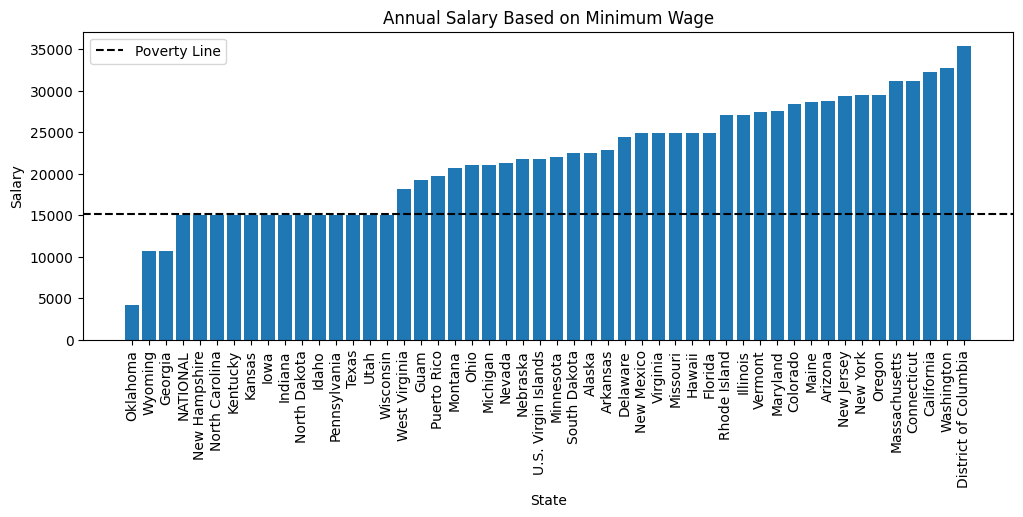

In [1528]:
df_min_wage_ORD = df_min_wage.sort_values(by='MW Salary 23').dropna()
plt.figure(figsize=(12, 4))
plt.bar(df_min_wage_ORD['State'], df_min_wage_ORD['MW Salary 23'])
plt.axhline(pov_value, color='black',linestyle='--', label=f'Poverty Line')
plt.ylabel('Salary')
plt.xlabel('State')
plt.title('Annual Salary Based on Minimum Wage')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### What is the living wage across the US?
*Note: Median living wage is also avaiable.*

**Source:** [Economic Policy Institute](https://files.epi.org/uploads/fbc_livingwage_data_2024.xlsx) **Year:** 2024

In [1529]:
df_liv_wage = pd.read_csv('Datasets/Living_Wage.csv')

# Remove columm of state abbreviations.
df_liv_wage = df_liv_wage.iloc[:, 1:]

# Reduce rows to include the 'standard' values.
df_liv_wage = df_liv_wage[~df_liv_wage['Unnamed: 2'].str.contains('Median', na=False)]

# Rename state column heading to 'State' and One adult, no children column to 'LW 24'
df_liv_wage = df_liv_wage.rename(columns={'Unnamed: 1': 'State', 'One adult, no children': 'LW 24'})

# Reduce columns to include 'all income from wages' values.
df_liv_wage.drop(df_liv_wage.columns[df_liv_wage.columns.str.contains('Unnamed|Summary')], axis=1, inplace=True)

# Combine information from first two rows.
df_liv_wage = df_liv_wage[1:]

# Use only data from one adult, no children.
df_liv_wage = df_liv_wage.iloc[:, :2]

# Convert data to numeric values.
df_liv_wage['LW 24'] = df_liv_wage['LW 24'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)

# Create column with annual salary for a 40 hour work week.
df_liv_wage['LW Salary 24'] = df_liv_wage['LW 24'] * 40 * 52

df_liv_wage = df_liv_wage.reset_index(drop=True)

df_combined = pd.merge(df_min_wage, df_liv_wage, left_on='State', right_on='State')

df_combined.head(3)

,State,MW 23,MW Salary 23,LW 24,LW Salary 24
0,Alabama,NaN,NaN,24.31,50564.8
1,Alaska,10.85,22568.0,28.02,58281.6
2,Arizona,13.85,28808.0,26.18,54454.4


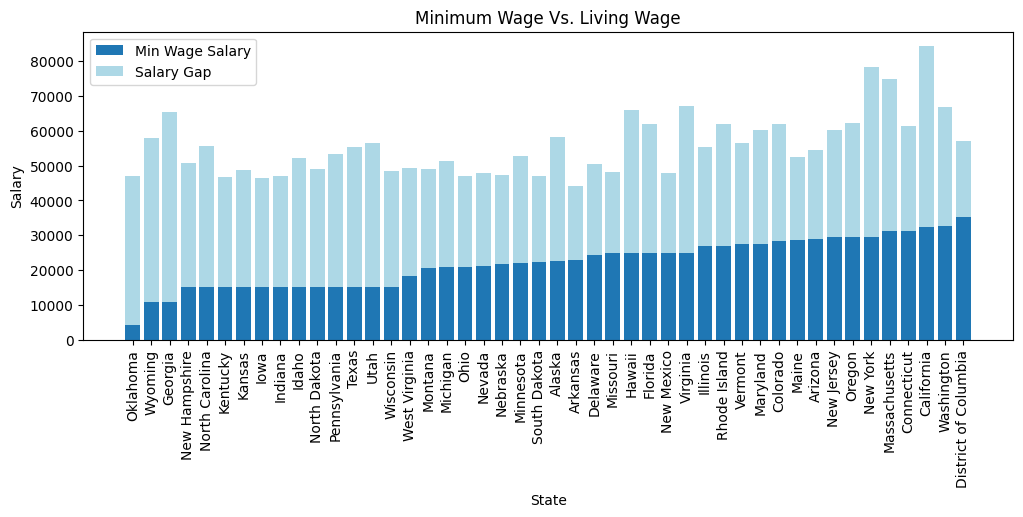

In [1530]:
df_combined_ORD = df_combined.sort_values(by='MW Salary 23').dropna()
df_combined_ORD['LW - MW'] = df_combined['LW Salary 24'] - df_combined['MW Salary 23']
plt.figure(figsize=(12, 4))
plt.bar(df_combined_ORD['State'], df_combined_ORD['MW Salary 23'], label='Min Wage Salary')
plt.bar(df_combined_ORD['State'], df_combined_ORD['LW - MW'], bottom=df_combined_ORD['MW Salary 23'], color='lightblue', label='Salary Gap')
plt.ylabel('Salary')
plt.xlabel('State')
plt.title('Minimum Wage Vs. Living Wage')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### What is the average (and median) income across the US?
**Source:** [US Census Bureau](https://data.census.gov/table/ACSST1Y2022.S1901?t=Income%20and%20Poverty&g=010XX00US,$0400000) **Year:** 2022

In [1531]:
df_salaries = pd.read_csv('Datasets/Average_Income.csv')

# Reduce columns to include only 'non-family' households, exlude margin of error columns.
df_salaries.drop(df_salaries.columns[~df_salaries.columns.str.contains('Nonfamily households!!Estimate|Label')], axis=1, inplace=True)

# Reduce rows to include income brackets, median, and mean.
df_salaries = df_salaries[df_salaries['Label (Grouping)'].str.contains('Mean|Median', na=False)]

# Transpose data set.
df_salaries = df_salaries.set_index('Label (Grouping)').T.reset_index().rename_axis(None, axis=1)

# Name first column 'State,' median salary to 'Med Salary 22,' and mean salary to 'Avg Salary 22.'
df_salaries = df_salaries.rename(columns={'index': 'State', 'Median income (dollars)': 'Med Salary 22', 'Mean income (dollars)': 'Avg Salary 22'})

# Rename values in 'State' column to just the state.
df_salaries['State'] = df_salaries['State'].str.replace('!!Nonfamily households!!Estimate', '', regex=True)

# Rename 'United States' value to 'NATIONAL.'
df_salaries = df_salaries.replace('United States', 'NATIONAL')

# Convert data in 'Median Salary' and 'Average Salary' to numeric values.
df_salaries['Avg Salary 22'] = df_salaries['Avg Salary 22'].str.replace(',', '', regex=True).astype(float)
df_salaries['Med Salary 22'] = df_salaries['Med Salary 22'].str.replace(',', '', regex=True).astype(float)

df_combined = pd.merge(df_combined, df_salaries, left_on='State', right_on='State')

df_combined.head(3)

,State,MW 23,MW Salary 23,LW 24,LW Salary 24,Med Salary 22,Avg Salary 22
0,Alabama,NaN,NaN,24.31,50564.8,32330.0,47145.0
1,Alaska,10.85,22568.0,28.02,58281.6,57657.0,74242.0
2,Arizona,13.85,28808.0,26.18,54454.4,47840.0,66724.0


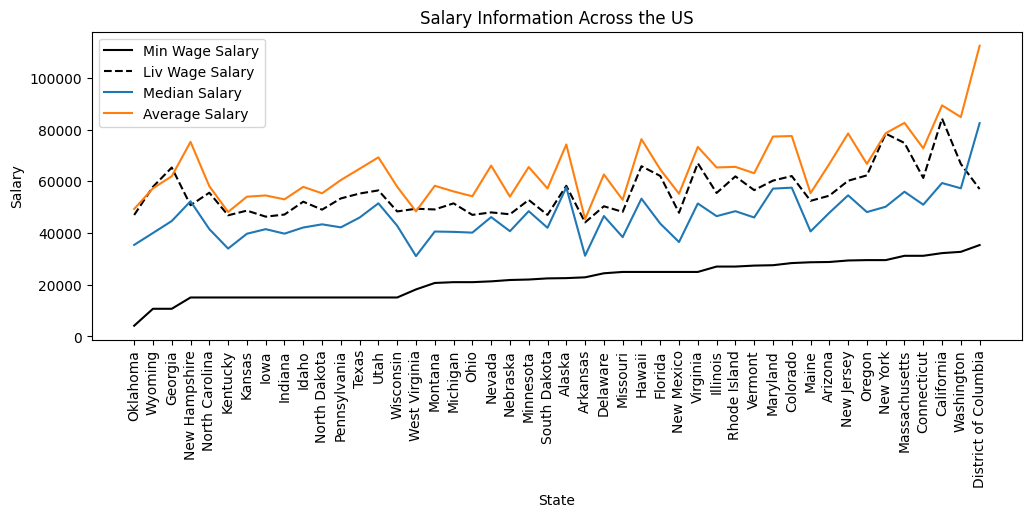

In [1532]:
df_combined_ORD = df_combined.sort_values(by='MW Salary 23').dropna()
plt.figure(figsize=(12, 4))
plt.plot(df_combined_ORD['State'], df_combined_ORD['MW Salary 23'], color='black', label='Min Wage Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['LW Salary 24'], color='black', linestyle='--', label='Liv Wage Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Med Salary 22'], label='Median Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Avg Salary 22'], label='Average Salary')
plt.ylabel('Salary')
plt.xlabel('State')
plt.title('Salary Information Across the US')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Teacher Wages

### What is the starting salary for teachers across the US?
**Source:** [National Education Association](https://www.nea.org/resource-library/educator-pay-and-student-spending-how-does-your-state-rank/starting-teacher) **Year:** FY 2022 - 2023

In [1533]:
df_star_sal = pd.read_csv('Datasets/Starting_Salary.csv')

# Select data from starting salary and top salary columns.
df_star_sal.drop(df_star_sal.columns[df_star_sal.columns.str.contains("'S")], axis=1, inplace=True)

# Convert data to numeric values.
df_star_sal['STARTING SALARY'] = df_star_sal['STARTING SALARY'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)
df_star_sal['TOP SALARY'] = df_star_sal['TOP SALARY'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)

# Rename columns in title case and years.
df_star_sal.columns = ['State', 'Start Salary 22-23 (T)', 'Top Salary 22-23 (T)']

# Rename 'Dist. of Columbia' to 'District of Columbia,' 'United States' to 'NATIONAL,' and remove '*' code from Texas.
df_star_sal = df_star_sal.replace('United States', 'NATIONAL')
df_star_sal = df_star_sal.replace('Dist. of Columbia', 'District of Columbia')
df_star_sal = df_star_sal.replace('Texas*', 'Texas')

df_combined = pd.merge(df_combined, df_star_sal, left_on='State', right_on='State')

df_combined.head(3)

,State,MW 23,MW Salary 23,LW 24,LW Salary 24,Med Salary 22,Avg Salary 22,Start Salary 22-23 (T),Top Salary 22-23 (T)
0,Alabama,NaN,NaN,24.31,50564.8,32330.0,47145.0,43679.0,88773.0
1,Alaska,10.85,22568.0,28.02,58281.6,57657.0,74242.0,51207.0,92052.0
2,Arizona,13.85,28808.0,26.18,54454.4,47840.0,66724.0,44124.0,73875.0


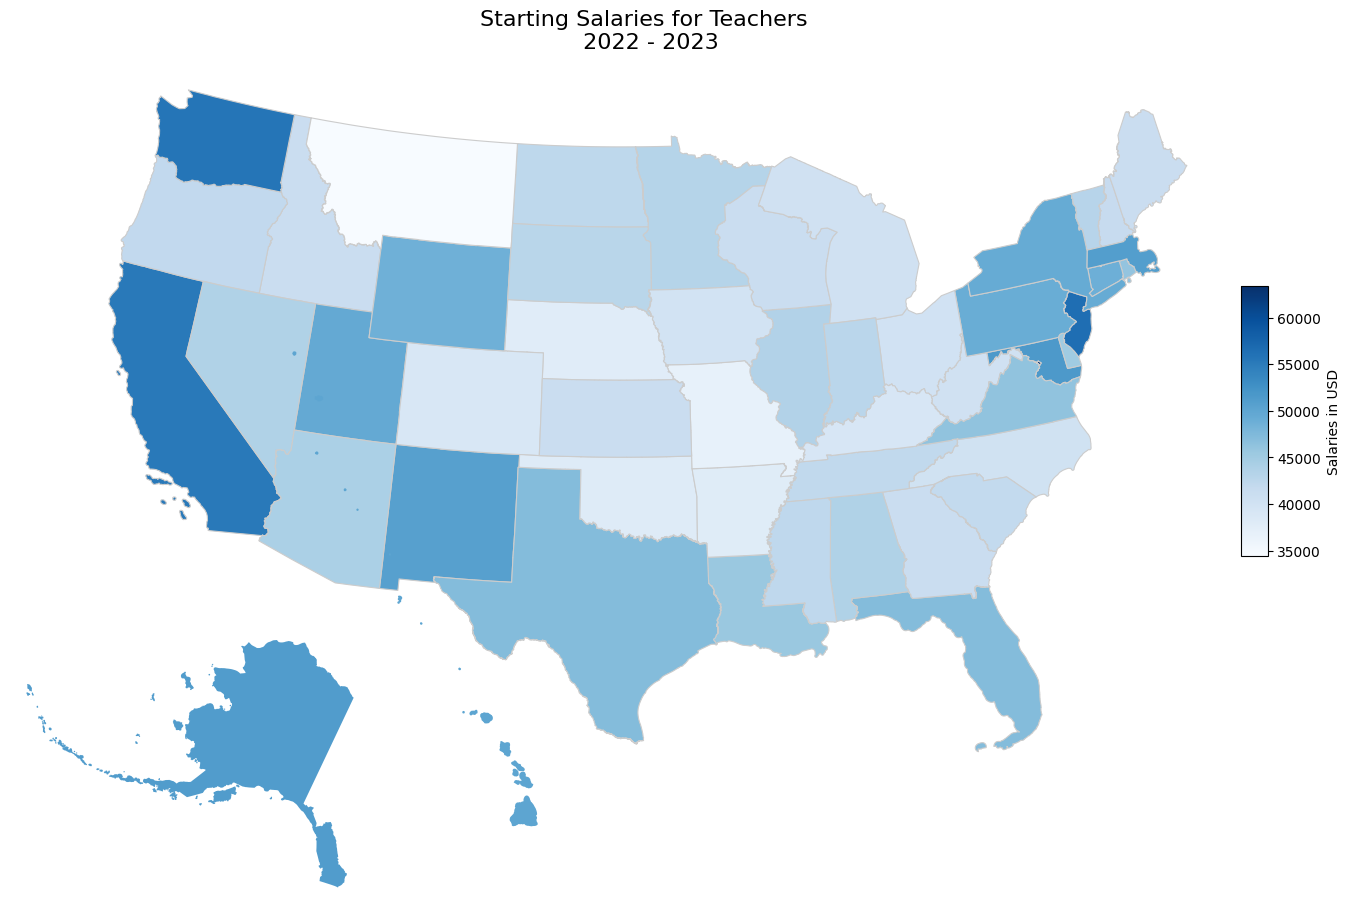

In [1534]:
states = gpd.read_file('tl_2023_us_state/tl_2023_us_state.shp')
states = states.to_crs('EPSG:2267')
states = states.merge(df_star_sal, left_on='NAME', right_on='State')

alaska = states[states['NAME'] == 'Alaska']
hawaii = states[states['NAME'] == 'Hawaii']
mainland = states[(states['NAME'] != 'Alaska') & (states['NAME'] != 'Hawaii')]

vmin = states['Start Salary 22-23 (T)'].min()
vmax = states['Start Salary 22-23 (T)'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = colormaps['Blues']

fig, ax_main = plt.subplots(1, 1, figsize=(18, 14))
ax_alaska = fig.add_axes([0.1, 0.15, 0.2, 0.2])  # [left, bottom, width, height]
ax_hawaii = fig.add_axes([0.25, 0.15, 0.15, 0.45])

mainland.plot(ax=ax_main, column='Start Salary 22-23 (T)', cmap=cmap, norm=norm, legend=True, 
    legend_kwds={'shrink': 0.25, 'pad': 0, 'aspect': 10, 'label': 'Salaries in USD'}, linewidth=0.8, edgecolor='0.8')
alaska.plot(ax=ax_alaska, column='Start Salary 22-23 (T)', cmap=cmap, norm=norm, legend=False)
hawaii.plot(ax=ax_hawaii, column='Start Salary 22-23 (T)', cmap=cmap, norm=norm, legend=False)

ax_main.set_axis_off()
ax_alaska.set_axis_off()
ax_hawaii.set_axis_off()

ax_main.set_title('Starting Salaries for Teachers \n 2022 - 2023', fontsize=16)
plt.show()

### What is the average salary for teachers across the US?
**Source:** [National Education Association](https://www.nea.org/resource-library/educator-pay-and-student-spending-how-does-your-state-rank/teacher) **Year:** 2022 - 2023

In [1535]:
df_avg_sal = pd.read_csv('Datasets/Average_Salary.csv')

# Remove rank (and percent) columns.
df_avg_sal.drop(df_avg_sal.columns[df_avg_sal.columns.str.contains('RANK|PERCENT')], axis=1, inplace=True)

# Rename columns to be title case and only years.
df_avg_sal.columns = ['State', 'Avg Salary 21-22 (T)', 'Avg Salary 22-23 (T)']

# Convert data to numeric values.
df_avg_sal['Avg Salary 21-22 (T)'] = df_avg_sal['Avg Salary 21-22 (T)'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)
df_avg_sal['Avg Salary 22-23 (T)'] = df_avg_sal['Avg Salary 22-23 (T)'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)

df_combined = pd.merge(df_combined, df_avg_sal, left_on='State', right_on='State')
df_combined.head(3)

,State,MW 23,MW Salary 23,LW 24,LW Salary 24,Med Salary 22,Avg Salary 22,Start Salary 22-23 (T),Top Salary 22-23 (T),Avg Salary 21-22 (T),Avg Salary 22-23 (T)
0,Alabama,NaN,NaN,24.31,50564.8,32330.0,47145.0,43679.0,88773.0,55882.0,60441.0
1,Alaska,10.85,22568.0,28.02,58281.6,57657.0,74242.0,51207.0,92052.0,74167.0,76371.0
2,Arizona,13.85,28808.0,26.18,54454.4,47840.0,66724.0,44124.0,73875.0,56775.0,60275.0


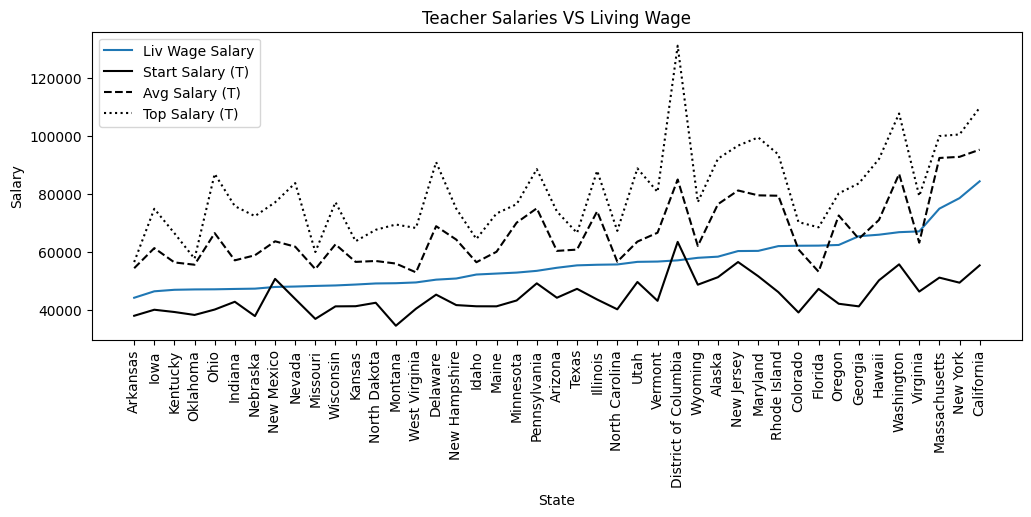

In [1536]:
df_combined_ORD = df_combined.sort_values(by='LW Salary 24').dropna()
plt.figure(figsize=(12, 4))
plt.plot(df_combined_ORD['State'], df_combined_ORD['LW Salary 24'], label='Liv Wage Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Start Salary 22-23 (T)'], color='black', label='Start Salary (T)')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Avg Salary 22-23 (T)'], color='black', linestyle='dashed', label='Avg Salary (T)')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Top Salary 22-23 (T)'], color='black', linestyle='dotted', label='Top Salary (T)')
plt.ylabel('Salary')
plt.xlabel('State')
plt.title('Teacher Salaries VS Living Wage')
plt.xticks(rotation=90)
plt.legend()
plt.show()

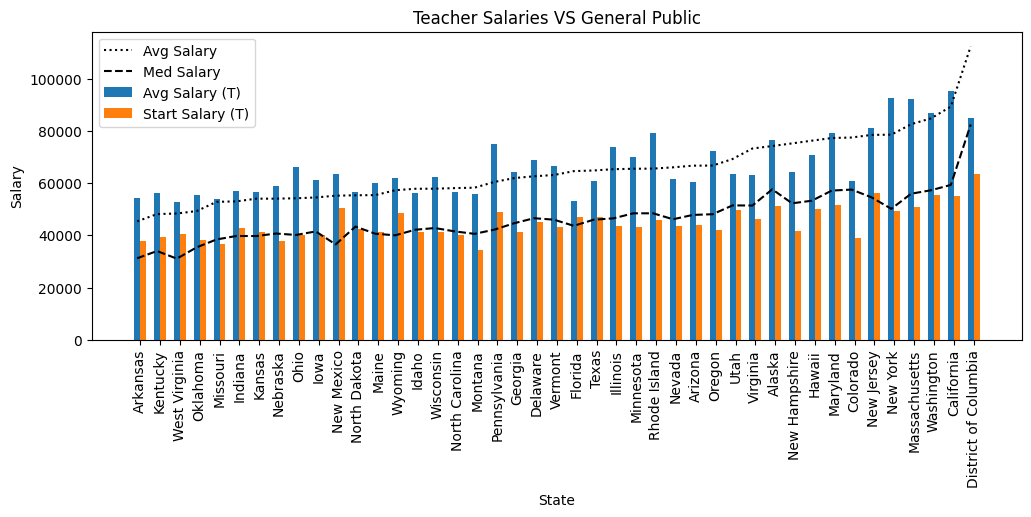

In [1537]:
df_combined_ORD = df_combined.sort_values(by='Avg Salary 22').dropna()

barWidth = 0.3

r1 = np.arange(len(df_combined_ORD['State']))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12, 4))
plt.plot(df_combined_ORD['State'], df_combined_ORD['Avg Salary 22'], color='black', linestyle='dotted', label='Avg Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Med Salary 22'], color='black', linestyle='dashed', label='Med Salary')
plt.bar(r1, df_combined_ORD['Avg Salary 22-23 (T)'], width=barWidth, label='Avg Salary (T)')
plt.bar(r2, df_combined_ORD['Start Salary 22-23 (T)'], width=barWidth, label='Start Salary (T)')
plt.ylabel('Salary')
plt.xlabel('State')
plt.title('Teacher Salaries VS General Public')
plt.xticks([r + barWidth / 2 for r in range(len(df_combined_ORD['State']))], df_combined_ORD['State'], rotation=90)
plt.legend()
plt.show()

# School Enrollment

### What is the school enrollment rate across the US?
**Source:** [United States Census Bureau](https://data.census.gov/table/ACSST1Y2022.S1401?t=Education&g=010XX00US,$0400000) **Year:** 2022

In [1538]:
df_enroll = pd.read_csv('Datasets/School_Enrollment.csv')

# Select rows that are '... year olds enrolled in school'
df_enroll = df_enroll[df_enroll['Label (Grouping)'].str.contains('year olds enrolled in school', na=False)]

# Keep columms '... Percent!!Estimate'
df_enroll.drop(df_enroll.columns[~df_enroll.columns.str.contains('Percent!!Estimate|Label')], axis=1, inplace=True)

# Transpose columns and rows.
df_enroll = df_enroll.set_index('Label (Grouping)').T.reset_index().rename_axis(None, axis=1)

# Shorten all column names.
df_enroll.columns = ['State', '3-4yo Enrolled 22', '5-9yo Enrolled 22', '10-14yo Enrolled 22', '15-17yo Enrolled 22', '18-19yo Enrolled 22', '20-24yo Enrolled 22', '25-34yo Enrolled 22']

# Reduce state data to include only the state.
df_enroll['State'] = df_enroll['State'].str.replace('!!Percent!!Estimate', '', regex=True)

# Change 'United States' to 'NATIONAL.'
df_enroll = df_enroll.replace('United States', 'NATIONAL')

# Change data to numeric.
df_enroll['3-4yo Enrolled 22'] = df_enroll['3-4yo Enrolled 22'].str.replace('%', '', regex=True).astype(float)
df_enroll['5-9yo Enrolled 22'] = df_enroll['5-9yo Enrolled 22'].str.replace('%', '', regex=True).astype(float)
df_enroll['10-14yo Enrolled 22'] = df_enroll['10-14yo Enrolled 22'].str.replace('%', '', regex=True).astype(float)
df_enroll['15-17yo Enrolled 22'] = df_enroll['15-17yo Enrolled 22'].str.replace('%', '', regex=True).astype(float)
df_enroll['18-19yo Enrolled 22'] = df_enroll['18-19yo Enrolled 22'].str.replace('%', '', regex=True).astype(float)
df_enroll['20-24yo Enrolled 22'] = df_enroll['20-24yo Enrolled 22'].str.replace('%', '', regex=True).astype(float)
df_enroll['25-34yo Enrolled 22'] = df_enroll['25-34yo Enrolled 22'].str.replace('%', '', regex=True).astype(float)

df_combined = pd.merge(df_combined, df_enroll, left_on='State', right_on='State')
df_combined.head(3)

,State,MW 23,MW Salary 23,LW 24,LW Salary 24,Med Salary 22,Avg Salary 22,Start Salary 22-23 (T),Top Salary 22-23 (T),Avg Salary 21-22 (T),Avg Salary 22-23 (T),3-4yo Enrolled 22,5-9yo Enrolled 22,10-14yo Enrolled 22,15-17yo Enrolled 22,18-19yo Enrolled 22,20-24yo Enrolled 22,25-34yo Enrolled 22
0,Alabama,NaN,NaN,24.31,50564.8,32330.0,47145.0,43679.0,88773.0,55882.0,60441.0,43.8,94.0,98.2,95.8,76.1,39.5,10.1
1,Alaska,10.85,22568.0,28.02,58281.6,57657.0,74242.0,51207.0,92052.0,74167.0,76371.0,41.9,94.3,97.9,97.5,47.2,19.5,8.9
2,Arizona,13.85,28808.0,26.18,54454.4,47840.0,66724.0,44124.0,73875.0,56775.0,60275.0,33.7,92.2,98.1,96.2,66.6,34.9,11.5


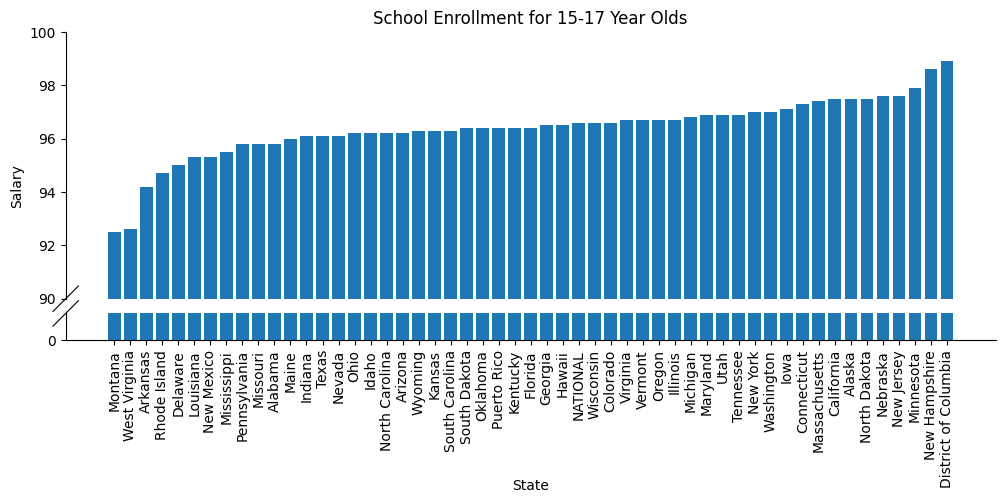

In [1544]:
df_enroll_ORD = df_enroll.sort_values(by='15-17yo Enrolled 22').dropna()
plt.figure(figsize=(12, 4))
bax = brokenaxes(ylims=((0, 1), (90, 100)), hspace=.1)
bax.bar(df_enroll_ORD['State'], df_enroll_ORD['15-17yo Enrolled 22'])
bax.set_xlabel('State')
bax.set_ylabel('Salary')
bax.axs[1].set_xticks(df_enroll_ORD['State'], labels=df_enroll_ORD['State'], rotation=90)
plt.xlabel('State', labelpad=100)
plt.title('School Enrollment for 15-17 Year Olds')
plt.show()

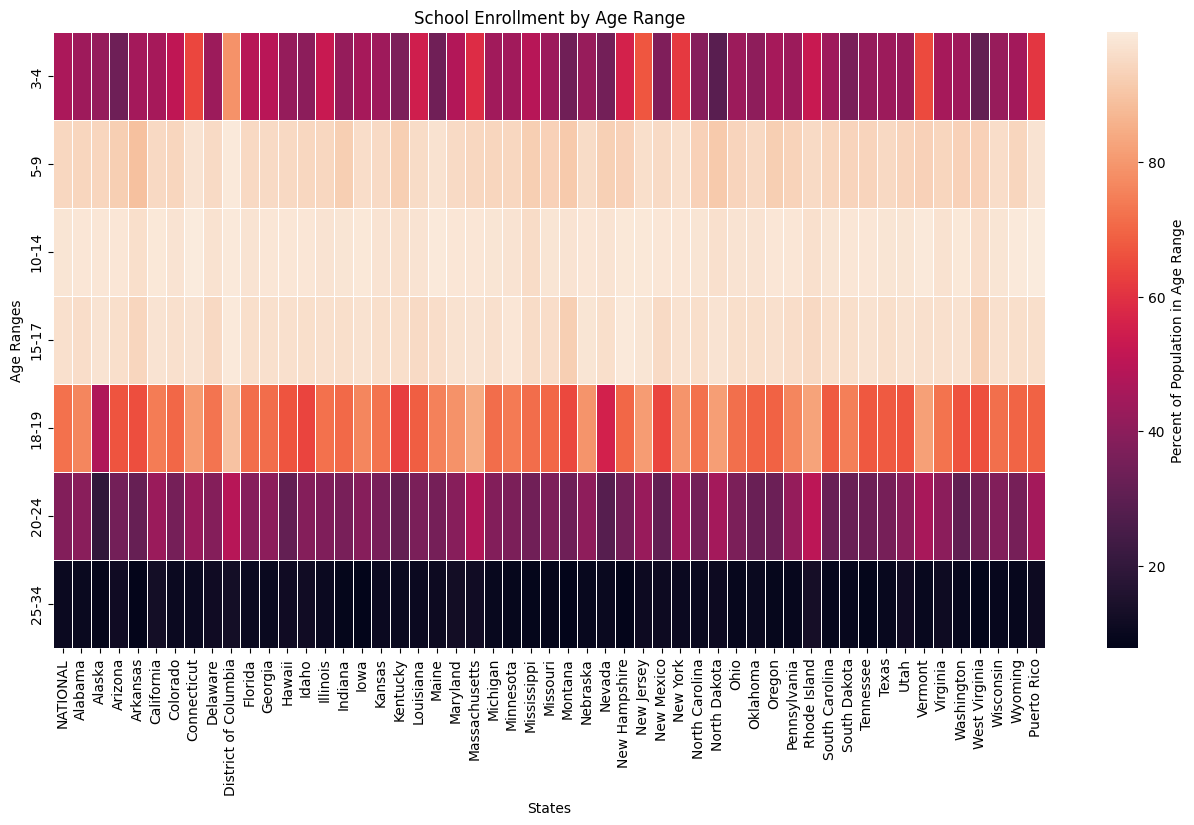

In [1540]:
df_heatmap = df_enroll.copy()
df_heatmap.columns = ['State', '3-4', '5-9', '10-14', '15-17', '18-19', '20-24', '25-34']
df_heatmap.set_index('State', inplace=True)
df_heatmap = df_heatmap.T
plt.figure(figsize=(16, 8))
sns.heatmap(df_heatmap, annot=False, cbar_kws={'label': 'Percent of Population in Age Range'}, linewidths=0.5, linecolor='white')
plt.title('School Enrollment by Age Range')
plt.xlabel('States')
plt.ylabel('Age Ranges')
plt.xticks(rotation=90)
plt.show()

# Summary

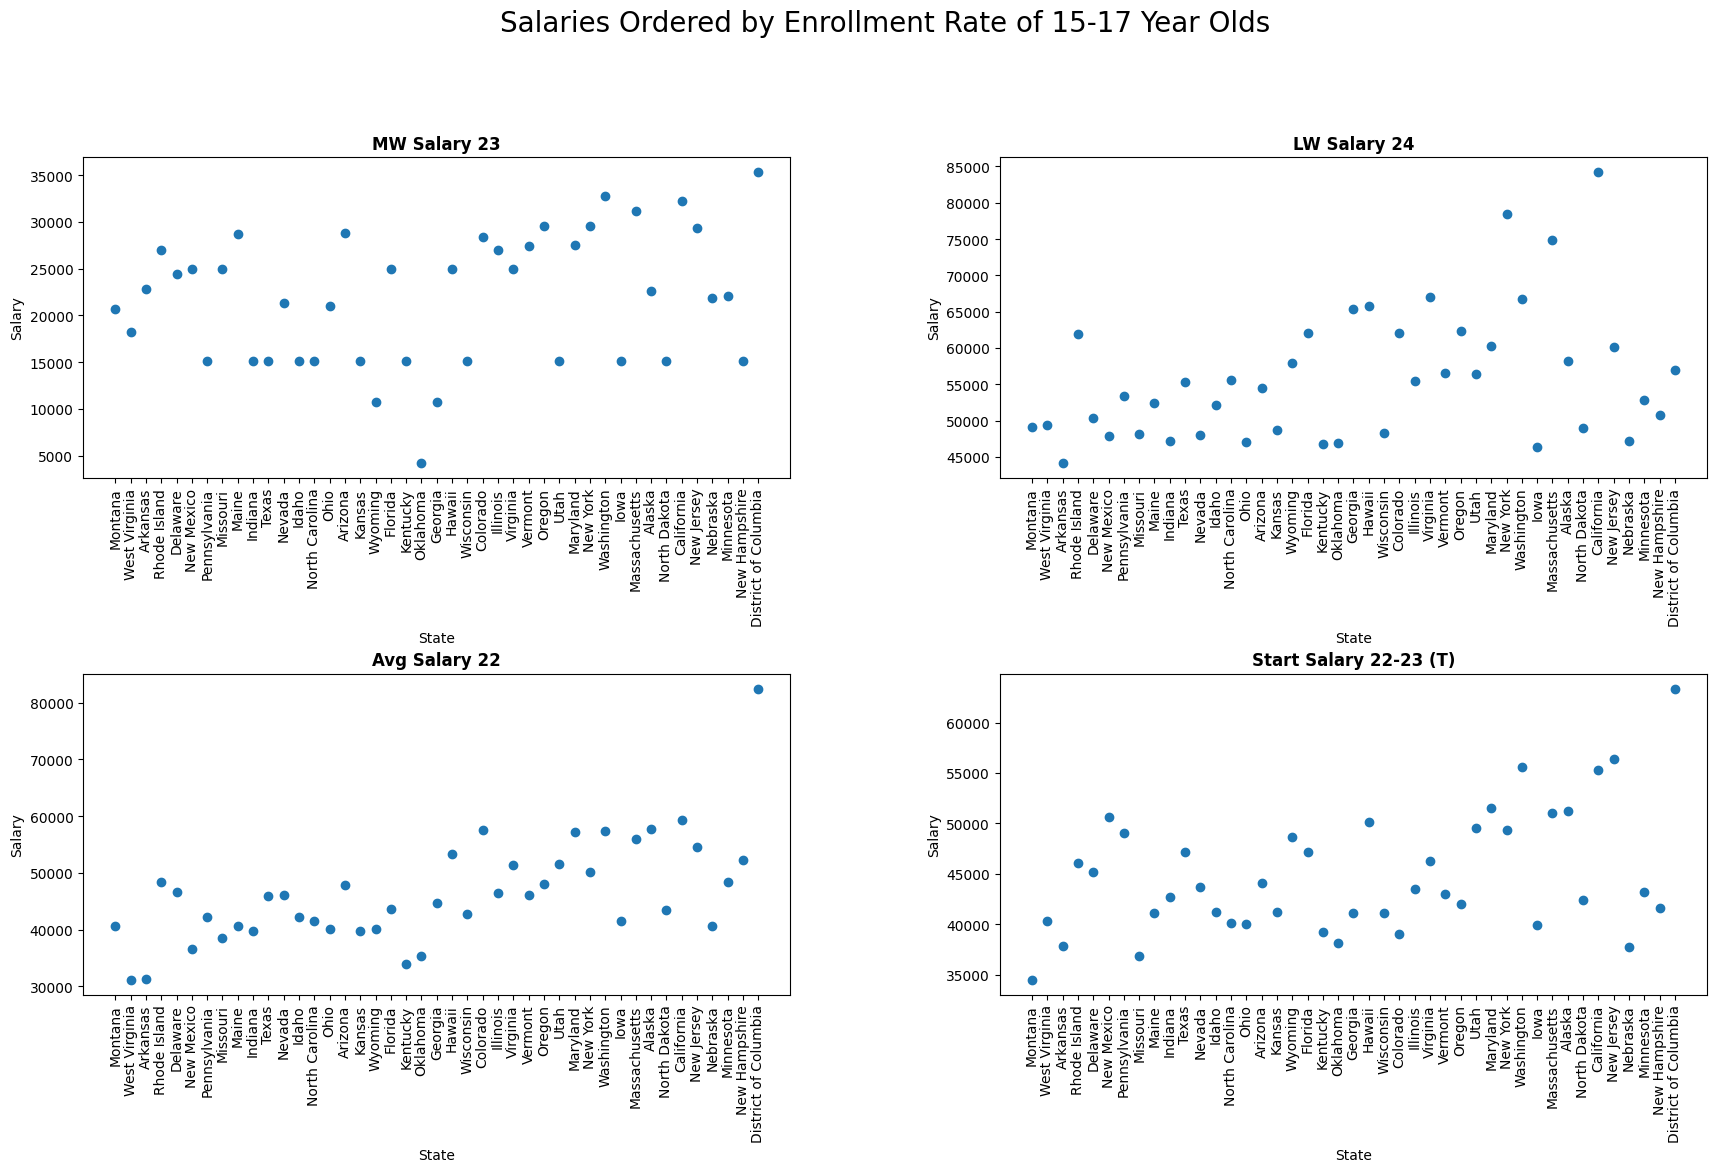

In [1541]:
df_combined_ORD = df_combined.sort_values(by='15-17yo Enrolled 22').dropna()

fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.tight_layout(pad=12)

axs[0,0].scatter(df_combined_ORD['State'], df_combined_ORD['MW Salary 23'])
axs[0,0].set_ylabel('Salary')
axs[0,0].set_xlabel('State')
axs[0,0].set_title(label='MW Salary 23', fontweight='bold')
axs[0,0].set_xticks(df_combined_ORD['State'], labels=df_combined_ORD['State'], rotation=90)

axs[0,1].scatter(df_combined_ORD['State'], df_combined_ORD['LW Salary 24'])
axs[0,1].set_ylabel('Salary')
axs[0,1].set_xlabel('State')
axs[0,1].set_title('LW Salary 24', fontweight='bold')
axs[0,1].set_xticks(df_combined_ORD['State'], labels=df_combined_ORD['State'], rotation=90)

axs[1,0].scatter(df_combined_ORD['State'], df_combined_ORD['Med Salary 22'])
axs[1,0].set_ylabel('Salary')
axs[1,0].set_xlabel('State')
axs[1,0].set_title('Avg Salary 22', fontweight='bold')
axs[1,0].set_xticks(df_combined_ORD['State'], labels=df_combined_ORD['State'], rotation=90)

axs[1,1].scatter(df_combined_ORD['State'], df_combined_ORD['Start Salary 22-23 (T)'])
axs[1,1].set_ylabel('Salary')
axs[1,1].set_xlabel('State')
axs[1,1].set_title('Start Salary 22-23 (T)', fontweight='bold')
axs[1,1].set_xticks(df_combined_ORD['State'], labels=df_combined_ORD['State'], rotation=90)

fig.suptitle('Salaries Ordered by Enrollment Rate of 15-17 Year Olds', fontsize=20)
plt.show()

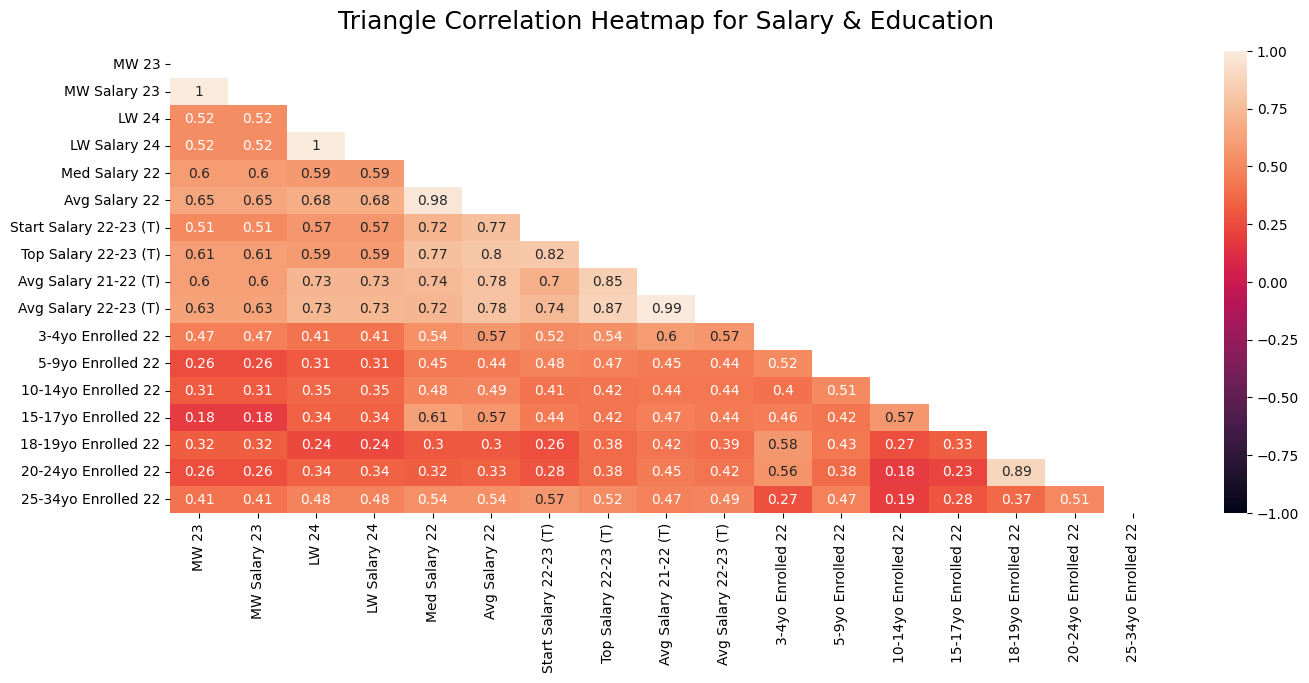

In [1542]:
df_combined.set_index('State', inplace=True)
np.triu(np.ones_like(df_combined.corr()))
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_combined.corr(), dtype=np.bool_))
heatmap = sns.heatmap(df_combined.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap for Salary & Education', fontdict={'fontsize':18}, pad=16);